In [2]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import zipfile

In [18]:
# Descargar y descomprimir dataset
!gdown 1RJo2y6ImtXDJaQ4KUKuZLXbZKtrsSnP0 -O ../Dataset_emocional.zip

zip_path = "../Dataset_emocional.zip"
extract_path = ".."

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Descomprimido en: {extract_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1RJo2y6ImtXDJaQ4KUKuZLXbZKtrsSnP0
From (redirected): https://drive.google.com/uc?id=1RJo2y6ImtXDJaQ4KUKuZLXbZKtrsSnP0&confirm=t&uuid=8f56b7d9-d0b9-4d52-8cb1-bcbc814ff369
To: c:\Users\cance\Documents\GitHub\Sentimental_emoji_classifier\Dataset_emocional.zip

  0%|          | 0.00/41.9M [00:00<?, ?B/s]
  1%|▏         | 524k/41.9M [00:01<01:21, 508kB/s]
  3%|▎         | 1.05M/41.9M [00:01<00:45, 903kB/s]
  4%|▍         | 1.57M/41.9M [00:01<00:29, 1.37MB/s]
  6%|▋         | 2.62M/41.9M [00:01<00:15, 2.50MB/s]
  9%|▉         | 3.67M/41.9M [00:01<00:10, 3.65MB/s]
 13%|█▎        | 5.24M/41.9M [00:01<00:06, 5.50MB/s]
 16%|█▋        | 6.82M/41.9M [00:01<00:04, 7.06MB/s]
 20%|██        | 8.39M/41.9M [00:02<00:04, 8.28MB/s]
 24%|██▍       | 9.96M/41.9M [00:02<00:03, 9.25MB/s]
 28%|██▊       | 11.5M/41.9M [00:02<00:03, 9.97MB/s]
 31%|███▏      | 13.1M/41.9M [00:03<00:06, 4.66MB/s]
 41%|████▏     | 17.3M/41.9M [00:03<00:02, 8.57MB/s]
 4

Downloading...
From (original): https://drive.google.com/uc?id=1RJo2y6ImtXDJaQ4KUKuZLXbZKtrsSnP0
From (redirected): https://drive.google.com/uc?id=1RJo2y6ImtXDJaQ4KUKuZLXbZKtrsSnP0&confirm=t&uuid=8f56b7d9-d0b9-4d52-8cb1-bcbc814ff369
To: c:\Users\cance\Documents\GitHub\Sentimental_emoji_classifier\Dataset_emocional.zip

  0%|          | 0.00/41.9M [00:00<?, ?B/s]
  1%|▏         | 524k/41.9M [00:01<01:21, 508kB/s]
  3%|▎         | 1.05M/41.9M [00:01<00:45, 903kB/s]
  4%|▍         | 1.57M/41.9M [00:01<00:29, 1.37MB/s]
  6%|▋         | 2.62M/41.9M [00:01<00:15, 2.50MB/s]
  9%|▉         | 3.67M/41.9M [00:01<00:10, 3.65MB/s]
 13%|█▎        | 5.24M/41.9M [00:01<00:06, 5.50MB/s]
 16%|█▋        | 6.82M/41.9M [00:01<00:04, 7.06MB/s]
 20%|██        | 8.39M/41.9M [00:02<00:04, 8.28MB/s]
 24%|██▍       | 9.96M/41.9M [00:02<00:03, 9.25MB/s]
 28%|██▊       | 11.5M/41.9M [00:02<00:03, 9.97MB/s]
 31%|███▏      | 13.1M/41.9M [00:03<00:06, 4.66MB/s]
 41%|████▏     | 17.3M/41.9M [00:03<00:02, 8.57MB/s]
 4

Descomprimido en: ..


In [3]:
# Cargar dataset
base_images_dir = Path("../Dataset_emocional")

# Crear datasets
ORIGINAL_IMG_SIZE = (28, 28)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

val_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"✓ Clases: {class_names}")
print(f"✓ Número de clases: {num_classes}")

# Optimizar datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 639 files belonging to 3 classes.


Using 512 files for training.
Found 639 files belonging to 3 classes.
Using 127 files for validation.
✓ Clases: ['Enojado', 'Feliz', 'Triste']
✓ Número de clases: 3


In [4]:
# Normalizar datos
train_ds_normalized = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds_normalized = val_ds.map(lambda x, y: (x / 255.0, y))

print("Datasets normalizados")

Datasets normalizados


In [182]:
# Construir CNN desde cero
cnn_model = models.Sequential([
    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Capa convolucional 3
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

print("✓ Modelo CNN creado")
cnn_model.summary()

✓ Modelo CNN creado


c:\Users\cance\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,987 (507.76 KB)

 Trainable params: 129,987 (507.76 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
# Compilar modelo
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo compilado")

Modelo compilado


In [184]:
# Entrenar modelo
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

epochs = 80

history = cnn_model.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

print("\nEntrenamiento completado")

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3750 - loss: 1.0980 - val_accuracy: 0.3858 - val_loss: 1.0954
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4082 - loss: 1.0886 - val_accuracy: 0.3858 - val_loss: 1.0942
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4043 - loss: 1.0932 - val_accuracy: 0.3858 - val_loss: 1.0919
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3965 - loss: 1.0877 - val_accuracy: 0.3858 - val_loss: 1.0891
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4160 - loss: 1.0826 - val_accuracy: 0.3858 - val_loss: 1.0846
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4180 - loss: 1.0853 - val_accuracy: 0.3858 - val_loss: 1.0820
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4355 - loss: 1.0761 - val_accuracy: 0.3858 - val_loss: 1.0759
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4492 - loss: 1.0730 - val_accuracy: 0.3858 - val_

In [190]:
# Guardar modelo
cnn_model.save("cnn_model_emociones.h5")
print("Modelo guardado como 'cnn_model_emociones.h5'")

Modelo guardado como 'cnn_model_emociones.h5'


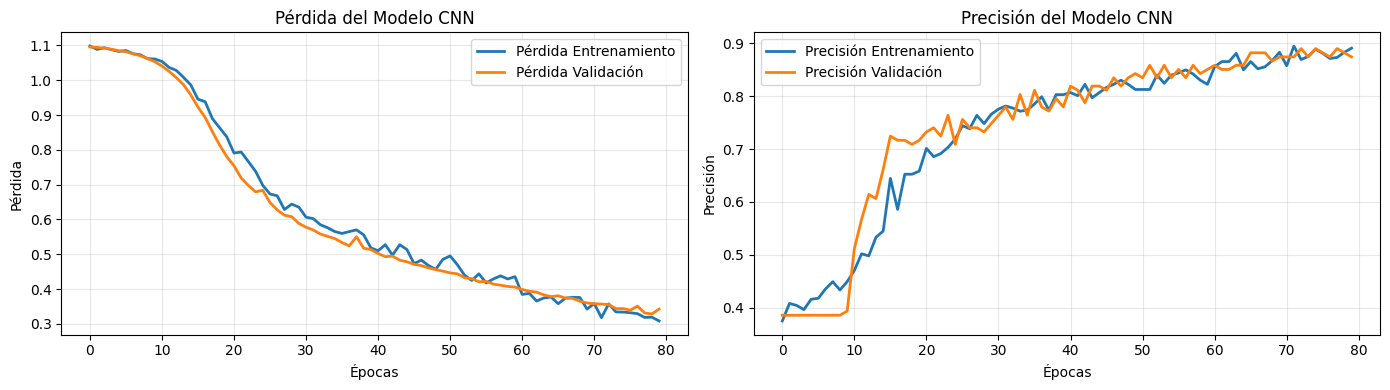

Épocas entrenadas: 80
Precisión final validación: 0.8740


In [186]:
# Gráficos de entrenamiento
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Pérdida Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Pérdida Validación', linewidth=2)
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Pérdida del Modelo CNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Precisión Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Precisión Validación', linewidth=2)
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].set_title('Precisión del Modelo CNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Precisión final validación: {history.history['val_accuracy'][-1]:.4f}")

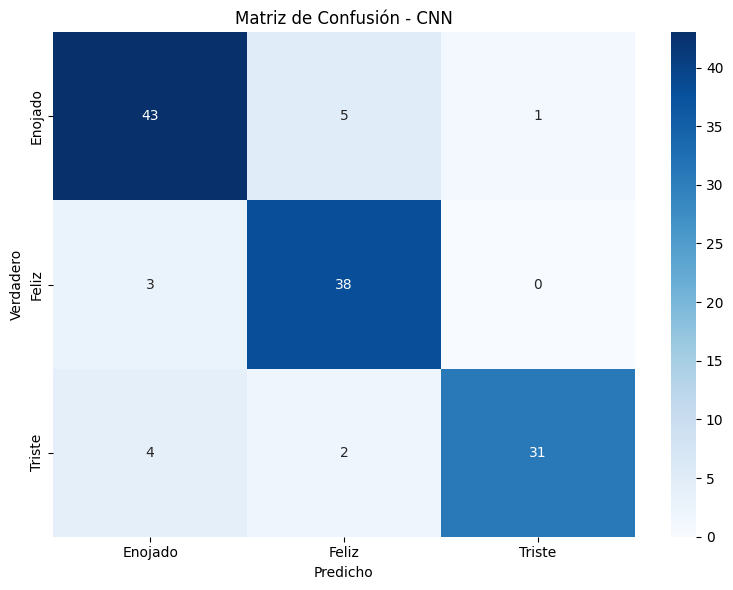


Reporte de Clasificación:
              precision    recall  f1-score   support

     Enojado       0.86      0.88      0.87        49
       Feliz       0.84      0.93      0.88        41
      Triste       0.97      0.84      0.90        37

    accuracy                           0.88       127
   macro avg       0.89      0.88      0.88       127
weighted avg       0.89      0.88      0.88       127



In [187]:
# Evaluar en validación
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for x_batch, y_batch in val_ds_normalized:
    predictions = cnn_model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - CNN')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [188]:
# Métricas globales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("="*50)
print("MÉTRICAS GLOBALES DEL MODELO CNN")
print("="*50)
print(f"Accuracy (Precisión General):  {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precision (Ponderada):         {precision:.4f}  ({precision*100:.2f}%)")
print(f"Recall (Sensibilidad):         {recall:.4f}  ({recall*100:.2f}%)")
print(f"F1 Score (Balance):            {f1:.4f}")
print("="*50)



MÉTRICAS GLOBALES DEL MODELO CNN
Accuracy (Precisión General):  0.8819  (88.19%)
Precision (Ponderada):         0.8867  (88.67%)
Recall (Sensibilidad):         0.8819  (88.19%)
F1 Score (Balance):            0.8822


In [15]:
import json
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": cm.tolist()  # convertir a lista para guardar en JSON
}

# Guardar JSON
with open("../src/pages/metricas.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

✓ Imagen: tanjiro-llorando.jpg
  Forma original: (432, 768, 3)
  Forma normalizada: (28, 28)


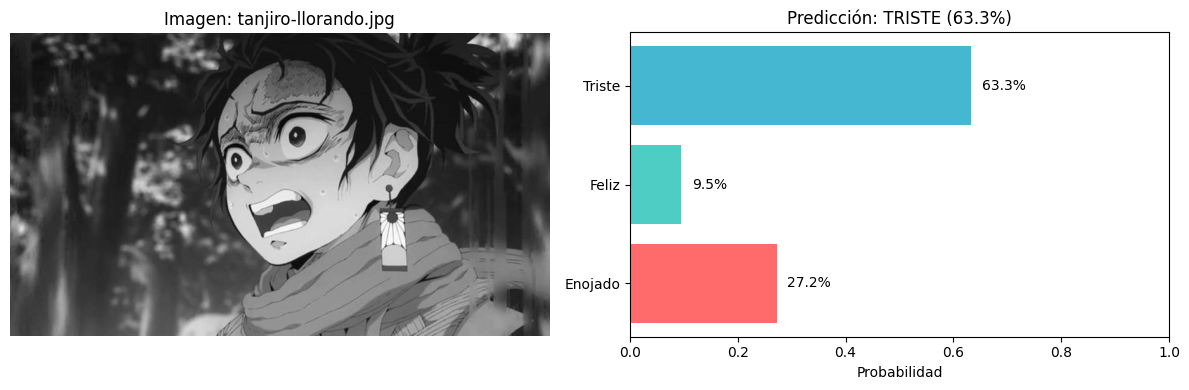


✓ Predicción: TRISTE
Confianza: 63.27%

Detalle de probabilidades:
  Enojado       27.22% ████████
  Feliz          9.51% ██
  Triste        63.27% ██████████████████


In [189]:
# Prueba con nueva imagen
import cv2

image_path = "C:/Users/cance/Downloads/tanjiro-llorando.jpg"  # Cambiar por tu imagen
image_path = Path(image_path)
    
if not image_path.exists():
    print(f"❌ No se encontró: {image_path}")
else:
    print(f"✓ Imagen: {image_path.name}")
    
    # Convertir a JPG si es PNG u otro formato
    if image_path.suffix.lower() != '.jpg':
        print(f"  Convirtiendo {image_path.suffix} a JPG...")
        img_original = cv2.imread(str(image_path))
        jpg_path = image_path.with_suffix('.jpg')
        cv2.imwrite(str(jpg_path), img_original, [cv2.IMWRITE_JPEG_QUALITY, 95])
        image_path = jpg_path
        print(f"  Guardado como: {jpg_path.name}")
    
    # Procesar con OpenCV
    img = cv2.imread(str(image_path))  # Leer imagen
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    img_resized = cv2.resize(img_gray, (28, 28))  # Redimensionar a 28x28
    img_normalized = img_resized.astype('float32') / 255.0  # Normalizar [0,1]
    img_input = img_normalized.reshape(1, 28, 28, 1)  # Reshape para modelo
    
    print(f"  Forma original: {img.shape}")
    print(f"  Forma normalizada: {img_normalized.shape}")
    
    # Predicción
    prediction = cnn_model.predict(img_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(img_gray, cmap='gray')
    axes[0].set_title(f"Imagen: {image_path.name}")
    axes[0].axis('off')
    
    probabilities = prediction[0]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    axes[1].barh(class_names, probabilities, color=colors)
    axes[1].set_xlabel('Probabilidad')
    axes[1].set_title(f'Predicción: {class_names[predicted_class].upper()} ({confidence*100:.1f}%)')
    axes[1].set_xlim([0, 1])
    
    for i, (emotion, prob) in enumerate(zip(class_names, probabilities)):
        axes[1].text(prob + 0.02, i, f'{prob*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Predicción: {class_names[predicted_class].upper()}")
    print(f"Confianza: {confidence*100:.2f}%")
    print(f"\nDetalle de probabilidades:")
    for emotion, prob in zip(class_names, probabilities):
        barra = "█" * int(prob * 30)
        print(f"  {emotion:12} {prob*100:6.2f}% {barra}")